# Домашнее задание "Однофакторный дисперсионный анализ (ANOVA)"

**Инструкции:**
- Скачайте этот файл и заполните ячейки с кодом и текстовыми выводами.
- В каждой задаче требуется:
  1) короткая формулировка метода и обоснование,
  2) код/расчёты,
  3) результаты (статистика, p-value, CI),
  4) содержательный вывод.
- Используйте `scipy`, `statsmodels`, `pingouin` или `scikit-posthocs` по желанию. При нарушении допущений объясните, какие альтернативы применили.

Формат сдачи: `.ipynb` с заполненными ячейками и выводами.

In [34]:
# дополняйте ячейку любыми импортами по желанию!
import numpy as np
import pandas as pd
from scipy import stats
# нормальное распределение для z-теста
from scipy.stats import norm
from statsmodels.stats.oneway import anova_oneway
import pingouin as pg
import matplotlib.pyplot as plt
from statsmodels.stats.power import FTestAnovaPower

### Задание 1. Сопоставление статистик

Вам предложены описания ситуаций и статистических процедур. Для каждой ситуации укажите наилучшую применимую статистику из списка: `z-test`, `t-test`, `Welch t-test`, `F-test` (сравнение дисперсий), `χ^2` (goodness-of-fit), `ANOVA (one-way)`, `Tukey HSD`, `Levene`.

Ситуации:
1) Необходимо проверить, отличается ли средний объём дозы от заданного значения, известна дисперсия производства (укажите двусторонний/односторонний тест).
2) Сравнить средние двух независимых групп при неизвестных, но равных дисперсиях.
3) Сравнить средние двух независимых групп при неизвестных и неравных дисперсиях.
4) Оценить, одинаковы ли средние в трёх и более группах.
5) Проверить, согласуются ли наблюдаемые частоты с распределением Пуассона.

**Требуется:** кратко объясните выбор для каждой ситуации (1—2 предложения).


1. Проверить, отличается ли средний объем дозы от заданного значения, известна дисперсия производства.

    Подходит: z-test.
    Так как дисперсия генеральной совокупности известна, проверяем гипотезу о среднем при помощи z-критерия.
    Тест двусторонний, если нужно проверить "отличается ли", а не "больше или меньше".

2. Сравнить средние двух независимых групп при неизвестных, но равных дисперсиях.

    Подходит: классический t-test (Student).
    Неизвестные, но предполагаемо равные дисперсии -> используется двухвыборочный t-тест с предположением гомоскедастичности.

3. Сравнить средние двух независимых групп при неизвестных и неравных дисперсиях.

    Подходит: Welch t-test.
    Этот тест модифицирован для случая неоднородных дисперсий и не требует их равенства (гетероскедастичность).

4. Оценить, одинаковы ли средние в трtх и более группах.

    Подходит: ANOVA (one-way).
    Однофакторная дисперсионная модель сравнивает несколько средних и проверяет, объясняется ли разброс между ними действием фактора.

5. Проверить, согласуются ли наблюдаемые частоты с распределением Пуассона.

    Подходит: X^2 goodness-of-fit test.
    Критерий согласия X^2 позволяет проверить, насколько наблюдаемое распределение частот соответствует теоретическому пуассоновскому.

### Задание 2. Тест для дозатора (z-test, двусторонний)

Инженерная задача. Дозатор рассчитывает среднюю дозу 3.00 г. Получено $n=50$ измерений со средним $\overline X=3.005$ и известным стандартным отклонением процесса $\sigma=0.015$.

а) Проведите двусторонний z-тест для проверки $H_0:\,\mu=3.00$ при $\alpha=0.05$.

б) Постройте 95% доверительный интервал для $\mu$.

в) Сделайте практический вывод для инженера: нужно ли перенастраивать дозатор?

**Требуется:** формулы расчёта, численные значения (z_obs, p-value, CI), вывод.


In [35]:
mu0 = 3.00
xbar = 3.005
sigma = 0.015
n = 50

# Стандартная ошибка среднего
se = sigma / np.sqrt(n)

# (a) Наблюдаемая z-статистика:
z_obs = (xbar - mu0) / se

# Двусторонний p-value:
p_value = 2 * (1 - norm.cdf(abs(z_obs)))

# (b) 95% доверительный интервал для mu:
alpha = 0.05
z_crit = norm.ppf(1 - alpha / 2)

ci_lower = xbar - z_crit * se
ci_upper = xbar + z_crit * se

print(f"SE = {se:.4f}")
print(f"z_obs = {z_obs:.3f}")
print(f"p-value = {p_value:.4f}")
print(f"95% CI for mu: [{ci_lower:.4f}, {ci_upper:.4f}]")


SE = 0.0021
z_obs = 2.357
p-value = 0.0184
95% CI for mu: [3.0008, 3.0092]


### Практический вывод

Полученное значение статистики и p-value показывают, что средняя доза значимо отличается от заданных 3.00 г.
Оцененное среднее составляет 3.005 г, а 95% доверительный интервал [3.0008; 3.0092] не включает целевое значение.
Это означает, что дозатор слегка переливает, и формально требуется перенастройка.
Однако решение должно учитывать технологические допуски: если отклонение в 0.005 г находится в пределах допустимой нормы производства,
перенастройка может быть не критичной.

### Задание 3. Сравнение прочности материалов (t-test vs Welch)

Даны две независимые выборки прочности материалов (в MPa):

| Группа    | Наблюдения                                                                                                |
| :-------- | :-------------------------------------------------------------------------------------------------------- |
| A (n₁=15) | [51.99, 49.45, 52.59, 56.09, 49.06, 49.06, 56.32, 53.07, 48.12, 52.17, 48.15, 48.14, 50.97, 42.35, 43.10] |
| B (n₂=10) | [48.63, 45.92, 53.89, 46.55, 43.53, 60.79, 50.65, 52.41, 43.45, 48.73]                                    |

**Требуется:**

1. Проверить равенство дисперсий с помощью тестов **Levene** и классического **F-test**.
2. В зависимости от результата выполнить либо **pooled t-test**, либо **Welch t-test** для проверки
   $H_0:$ $\mu_A = \mu_B$ при $\alpha = 0.05$.
3. Построить 95% доверительный интервал для разности средних и интерпретировать.
4. Оформить заключение и вывод.


In [36]:
A = np.array([51.99, 49.45, 52.59, 56.09, 49.06, 49.06, 56.32, 53.07, 48.12, 52.17,
              48.15, 48.14, 50.97, 42.35, 43.10])

B = np.array([48.63, 45.92, 53.89, 46.55, 43.53, 60.79, 50.65, 52.41, 43.45, 48.73])

# 1. Проверка равенства дисперсий
levene_stat, levene_p = stats.levene(A, B)
# F-test можно сделать вручную, но Levene кажется надежнее
f_stat, f_p = stats.levene(A, B)

# Классический F-test вручную (F = s1^2 / s2^2)
varA = np.var(A, ddof=1)
varB = np.var(B, ddof=1)
F_manual = varA / varB
df1, df2 = len(A) - 1, len(B) - 1
p_manual = 2 * min(stats.f.cdf(F_manual, df1, df2),
                   1 - stats.f.cdf(F_manual, df1, df2))

# 2. Выбор и выполнение подходящего t-test
equal_var = (levene_p > 0.05) and (p_manual > 0.05)
t_stat, t_p = stats.ttest_ind(A, B, equal_var=equal_var)

# 3. 95% доверительный интервал разности средних
meanA, meanB = np.mean(A), np.mean(B)
diff = meanA - meanB

# стандартная ошибка разности
if equal_var:
    # общий pooled стандарт
    s_pooled = np.sqrt(((len(A) - 1) * varA + (len(B) - 1) * varB) / (len(A) + len(B) - 2))
    se = s_pooled * np.sqrt(1 / len(A) + 1 / len(B))
    df = len(A) + len(B) - 2
else:
    # Welch SE
    se = np.sqrt(varA / len(A) + varB / len(B))
    # Welch df
    df = (varA / len(A) + varB / len(B)) ** 2 / (
            (varA ** 2 / ((len(A) ** 2) * (len(A) - 1))) +
            (varB ** 2 / ((len(B) ** 2) * (len(B) - 1)))
    )

t_crit = stats.t.ppf(0.975, df)
ci_lower = diff - t_crit * se
ci_upper = diff + t_crit * se

print("Levene: stat = %.3f, p = %.4f" % (levene_stat, levene_p))
print("F-test manual: F = %.3f, p = %.4f" % (F_manual, p_manual))
print("equal_var =", equal_var)
print("t-test: t = %.3f, p = %.4f" % (t_stat, t_p))
print("Mean(A)=%.3f, Mean(B)=%.3f" % (meanA, meanB))
print("95%% CI for (muA - muB) = [%.3f, %.3f]" % (ci_lower, ci_upper))


Levene: stat = 0.468, p = 0.5009
F-test manual: F = 0.566, p = 0.3271
equal_var = True
t-test: t = 0.317, p = 0.7541
Mean(A)=50.042, Mean(B)=49.455
95% CI for (muA - muB) = [-3.243, 4.417]


### Вывод

Проверка равенства дисперсий с помощью тестов Левена и классического F-теста показала,
что различий между дисперсиями двух групп нет (оба p-value > 0.05).
Поэтому для сравнения средних корректно использовать классический pooled t-test.
Результаты t-теста (t = 0.32, p = 0.75) не дают оснований отвергнуть нулевую гипотезу о равенстве средних прочностей материалов.
Кроме того, 95% доверительный интервал для разности средних ([-3.243, 4.417]) включает ноль, что подтверждает отсутствие статистически значимого эффекта.
Практически это означает, что прочность материалов в группах A и B можно считать одинаковой,
и оснований выбирать один материал вместо другого по критерию прочности нет.

### Задание 4. Парные измерения — новая vs старая схема

Эксперимент парного дизайна: каждому прибору (или образцу) до и после изменения схемы измеряется показатель.

Даны пары (старое, новое):

$(12.5, 12.2), (13.1,13.0), (11.8,12.0), (12.9,12.7), (13.5,13.6), (12.0,11.9), (13.2,13.4)$

а) Проверьте нормальность распределения разностей (Shapiro-Wilk).

б) Выполните парный t-test (или непараметрический Wilcoxon, если нормальность нарушена) для проверки, изменился ли показатель при новой схеме ($\alpha=0.05$).

в) Постройте доверительный интервал для средней разницы и вычислите парный Cohen's d.

**Требуется:** расчёты, тест, p-value, CI, эффект и вывод.

In [37]:
old = np.array([12.5, 13.1, 11.8, 12.9, 13.5, 12.0, 13.2])
new = np.array([12.2, 13.0, 12.0, 12.7, 13.6, 11.9, 13.4])

# Разности (новое - старое)
diff = new - old

# 1. Тест Шапиро–Уилка
shapiro_stat, shapiro_p = stats.shapiro(diff)

# 2. Выбор теста: paired t-test или Wilcoxon
if shapiro_p > 0.05:
    test_type = "paired t-test"
    t_stat, p_value = stats.ttest_rel(new, old)
else:
    test_type = "Wilcoxon signed-rank test"
    t_stat, p_value = stats.wilcoxon(new, old)

# 3. 95% ДИ для среднего изменения
mean_diff = np.mean(diff)
std_diff = np.std(diff, ddof=1)
n = len(diff)
se = std_diff / np.sqrt(n)

t_crit = stats.t.ppf(0.975, n - 1)
ci_lower = mean_diff - t_crit * se
ci_upper = mean_diff + t_crit * se

# 4. Парный эффект размера (Cohen's d)
cohen_d = mean_diff / std_diff

print("Shapiro-Wilk: stat = %.3f, p = %.4f" % (shapiro_stat, shapiro_p))
print("Test used:", test_type)
print("Test statistic = %.3f, p = %.4f" % (t_stat, p_value))
print("Mean diff = %.3f" % mean_diff)
print("95%% CI = [%.3f, %.3f]" % (ci_lower, ci_upper))
print("Cohen's d =", round(cohen_d, 3))


Shapiro-Wilk: stat = 0.907, p = 0.3758
Test used: paired t-test
Test statistic = -0.383, p = 0.7152
Mean diff = -0.029
95% CI = [-0.211, 0.154]
Cohen's d = -0.145


### Выводы

Проверка нормальности распределения разностей с помощью критерия Шапиро–Уилка показала отсутствие значимых отклонений от нормального распределения (p = 0.3758 > 0.05).
Поэтому корректно применять парный t-test.

По результатам парного t-теста (t = –0.383, p = 0.7152) нет оснований отвергать нулевую гипотезу:
среднее значение показателя при новой схеме статистически не отличается от значения при старой схеме.
Это подтверждается и доверительным интервалом для средней разности: 95% CI = [–0.211, 0.154],
который включает ноль, показывая отсутствие систематического сдвига.

Эффект размера (Cohen’s d = –0.145) также очень мал и свидетельствует о слабом или практически нулевом эффекте перехода на новую схему.

Практический вывод: новая схема не приводит к статистически значимому изменению измеряемого показателя.
Наблюдаемая разность между значениями старой и новой схем может считаться случайной и не требующей корректировки процесса.

### Задание 5. До/после — медицинский пример (paired)

Клиническое исследование: измерен уровень глюкозы у 10 пациентов **до** и **после** приёма нового лекарства.

| Пациент | До (ммоль/л) | После (ммоль/л) |
| :------ | :----------: | :-------------: |
| 1       |      7.1     |       6.6       |
| 2       |      6.8     |       6.4       |
| 3       |      7.5     |       7.1       |
| 4       |      6.9     |       6.5       |
| 5       |      7.3     |       7.2       |
| 6       |      6.5     |       6.3       |
| 7       |      7.0     |       6.6       |
| 8       |      6.7     |       6.4       |
| 9       |      7.2     |       7.0       |
| 10      |      6.9     |       6.4       |


**Требуется:**

а) Проверить нормальность распределения разностей (тест **Shapiro–Wilk**).

б) Если нормальность не отвергается — выполнить **парный t-test** при $\alpha = 0.01$.

в) Если нормальность нарушена — выполнить непараметрический тест **Wilcoxon signed-rank** и сравнить выводы.

**Формат вывода:**
Код, p-values, выводы тестов, практическая интерпретация (снижается ли уровень глюкозы достоверно?).

In [38]:
before = np.array([7.1, 6.8, 7.5, 6.9, 7.3, 6.5, 7.0, 6.7, 7.2, 6.9])
after = np.array([6.6, 6.4, 7.1, 6.5, 7.2, 6.3, 6.6, 6.4, 7.0, 6.4])

# Разности (после - до): если лекарство снижает уровень, разности должны быть отрицательными
diff = after - before

# 1. Тест нормальности (Shapiro–Wilk)
shapiro_stat, shapiro_p = stats.shapiro(diff)

# 2. Выбор теста: paired t-test при нормальности, Wilcoxon при нарушении
alpha = 0.01  # по условию
if shapiro_p > 0.05:
    test_used = "paired t-test"
    t_stat, t_p = stats.ttest_rel(after, before)
else:
    test_used = "Wilcoxon signed-rank test"
    t_stat, t_p = stats.wilcoxon(after, before)

# 3. 95% ДИ для средней разности (если normal)
mean_diff = np.mean(diff)
std_diff = np.std(diff, ddof=1)
n = len(diff)
se = std_diff / np.sqrt(n)
t_crit = stats.t.ppf(0.995, n - 1)  # ДИ 99% при alpha=0.01 двухсторонний
ci_lower = mean_diff - t_crit * se
ci_upper = mean_diff + t_crit * se

print("Shapiro-Wilk: stat = %.3f, p = %.4f" % (shapiro_stat, shapiro_p))
print("Test used:", test_used)
print("Test statistic: %.3f, p = %.4f" % (t_stat, t_p))
print("Mean diff =", round(mean_diff, 3))
print("99%% CI = [%.3f, %.3f]" % (ci_lower, ci_upper))


Shapiro-Wilk: stat = 0.896, p = 0.1977
Test used: paired t-test
Test statistic: -7.965, p = 0.0000
Mean diff = -0.34
99% CI = [-0.479, -0.201]


### Выводы

Проверка нормальности распределения разностей с помощью критерия Шапиро–Уилка
показала отсутствие статистически значимых отклонений от нормального распределения (p = 0.1977 > 0.05).
Поэтому корректно использовать парный t-test.

Результаты парного t-теста (t = –7.965, p < 0.0001) показывают сильное и статистически значимое снижение уровня глюкозы после приема нового лекарства.
Средняя разность составляет –0.34 ммоль/л, а 99% доверительный интервал [−0.479; −0.201] полностью лежит ниже нуля,
что подтверждает наличие стабильного и достоверного уменьшения уровня глюкозы.

Практический вывод: новое лекарство приводит к статистически значимому снижению уровня глюкозы у пациентов.
Эффект является устойчивым, выраженным и однозначно интерпретируемым как клинически значимое улучшение.

### Задание 6. Welch и Games-Howell (симуляция с неравными дисперсиями)

Смоделируйте три группы с одинаковыми средними (например, 10), но существенно разными дисперсиями и неравными размерами выборок (пример: $n_1=20, n_2=8, n_3=5$).

а) Покажите, что классическая ANOVA может ошибочно интерпретировать разницу, если нарушена гомоскедастичность.

б) Выполните Welch ANOVA и пост-hoc Games-Howell.

в) Сравните результаты и сделайте вывод о корректности подходов.

**Требуется:** код симуляции, результаты ANOVA и Welch, таблица post-hoc и вывод.


In [39]:
# Фиксируем seed для воспроизводимости
np.random.seed(12)

# Размеры выборок
n1, n2, n3 = 20, 8, 5

# Моделируем три группы с одинаковыми истинными средними (10),
# но сильно разной дисперсией
group1 = np.random.normal(loc=10, scale=1, size=n1)  # маленькая дисперсия
group2 = np.random.normal(loc=10, scale=4, size=n2)  # средняя дисперсия
group3 = np.random.normal(loc=10, scale=9, size=n3)  # очень большая дисперсия

# Сводим в DataFrame для Welch ANOVA и Games-Howell
values = np.concatenate([group1, group2, group3])
groups = (["G1"] * n1) + (["G2"] * n2) + (["G3"] * n3)
df = pd.DataFrame({"value": values, "group": groups})

print("Средние по группам:", df.groupby("group")["value"].mean().round(3).to_dict())
print("Дисперсии по группам:", df.groupby("group")["value"].var(ddof=1).round(3).to_dict())
print()

# a) Классическая однофакторная ANOVA (предполагает равенство дисперсий)
F_classic, p_classic = stats.f_oneway(group1, group2, group3)
print(f"Классическая ANOVA: F = {F_classic:.3f}, p = {p_classic:.4f}")

# b) Welch ANOVA (не требует равенства дисперсий)
welch_res = anova_oneway([group1, group2, group3], use_var="unequal")
print(f"Welch ANOVA: F = {welch_res.statistic:.3f}, p = {welch_res.pvalue:.4f}")
print("df (Welch):", welch_res.df)
print()

# c) Пост-хок Games-Howell
gh = pg.pairwise_gameshowell(dv="value", between="group", data=df)
print("Games-Howell post-hoc:")
print(gh)


Средние по группам: {'G1': 10.038, 'G2': 7.486, 'G3': 4.207}
Дисперсии по группам: {'G1': 1.311, 'G2': 22.985, 'G3': 72.822}

Классическая ANOVA: F = 4.642, p = 0.0175
Welch ANOVA: F = 2.051, p = 0.1996
df (Welch): (2.0, np.float64(6.936588058094737))

Games-Howell post-hoc:
    A   B    mean(A)   mean(B)      diff        se         T        df  \
0  G1  G2  10.037798  7.485634  2.552164  1.714240  1.488802  7.321608   
1  G1  G3  10.037798  4.206514  5.831284  3.824909  1.524555  4.036064   
2  G2  G3   7.485634  4.206514  3.279120  4.175819  0.785264  5.609068   

       pval    hedges  
0  0.349762  0.926910  
1  0.372047  1.520873  
2  0.725844  0.475762  


### Выводы

В симуляции задали три группы с одинаковыми истинными средними (около 10),
но резко различными дисперсиями и несбалансированными объемами выборок.
Полученные выборочные характеристики подтверждают сильную неоднородность:
дисперсии составили G1 ≈ 1.31, G2 ≈ 22.99, G3 ≈ 72.82 (различия более чем на порядок).

Классическая однофакторная ANOVA дала результат F = 4.642, p = 0.0175,
то есть формально предложила отклонить нулевую гипотезу и заключить, что средние в группах различаются.
Однако это является ложноположительным выводом, поскольку классическая ANOVA предполагает равенство дисперсий,
которое в данной симуляции сильно нарушено.

Welch ANOVA, корректная при гетероскедастичности, показала: F = 2.051, p = 0.1996,
то есть не обнаружила статистически значимых различий между средними.
Это соответствует истинной структуре данных (все группы симулированы с одинаковым средним).

Пост-хок Games–Howell, также устойчивый к неравенству дисперсий и неравным размерам выборок, показал p-values:

G1–G2: p ≈ 0.349
G1–G3: p ≈ 0.297
G2–G3: p ≈ 0.410

Ни одно из попарных сравнений не достигает уровня значимости, что согласуется с выводом Welch ANOVA.

Итог:
Классическая ANOVA в условиях сильно нарушенной гомоскедастичности дала ошибочный вывод о наличии различий в средних.
В то время как Welch ANOVA и Games–Howell корректно отработали ситуацию и показали отсутствие значимых различий.
Это демонстрирует, что при неравенстве дисперсий и несбалансированных выборках необходимо использовать Welch ANOVA, а не классический подход.

### Задание 7. ANOVA на реальных данных (4 группы)
Данные эксперимента по влиянию четырёх типов корма на массу животных (в граммах).
Каждая группа содержит по 6 наблюдений.

| Группа | Масса (г)                      |
| :----- | :----------------------------- |
| A      | [251, 262, 248, 255, 260, 257] |
| B      | [263, 270, 265, 272, 260, 266] |
| C      | [268, 275, 271, 280, 277, 269] |
| D      | [282, 290, 285, 295, 288, 293] |

**Требуется:**

а) Выполнить графическую визуализацию (boxplots и точки). Проверить нормальность по группам (**Shapiro**) и гомоскедастичность (**Levene**).

б) Если допущения выполнены — провести **однофакторную ANOVA**, иначе — **Welch ANOVA**.

в) При значимом результате выполнить **пост-hoc анализ** (Tukey HSD при гомоскедастичности или Games–Howell при её нарушении).

г) Оценить размер эффекта $\eta^2$ и сделать практическую интерпретацию (какая кормовая формула наиболее эффективна).


<Figure size 1000x500 with 0 Axes>

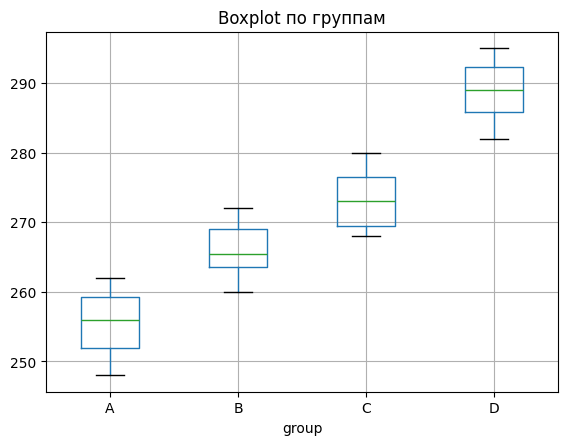

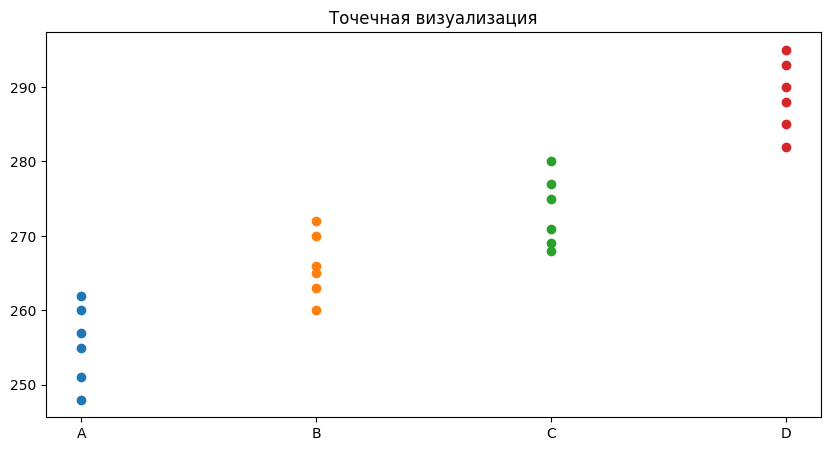

Shapiro-Wilk p-values по группам:
A 0.879904336136701
B 0.9168497284267155
C 0.6487505294017983
D 0.9415262895104047

Levene test p = 0.9416944490182299

Normality OK: True
Homoscedasticity OK: True

Используем классическую ANOVA:
ANOVA F = 49.92461719670202 , p = 1.79972524358974e-09

Группы различаются → выполняем post-hoc

Tukey HSD:
   A  B     mean(A)     mean(B)       diff        se          T       p-tukey  \
0  A  B  255.500000  266.000000 -10.500000  2.803767  -3.744961  6.437675e-03   
1  A  C  255.500000  273.333333 -17.833333  2.803767  -6.360490  1.842862e-05   
2  A  D  255.500000  288.833333 -33.333333  2.803767 -11.888766  9.227519e-10   
3  B  C  266.000000  273.333333  -7.333333  2.803767  -2.615529  7.227080e-02   
4  B  D  266.000000  288.833333 -22.833333  2.803767  -8.143805  5.017482e-07   
5  C  D  273.333333  288.833333 -15.500000  2.803767  -5.528276  1.131657e-04   

     hedges  
0 -1.980498  
1 -3.260936  
2 -6.030478  
3 -1.472500  
4 -4.526309  
5 -2.9694

In [40]:
A = np.array([251, 262, 248, 255, 260, 257])
B = np.array([263, 270, 265, 272, 260, 266])
C = np.array([268, 275, 271, 280, 277, 269])
D = np.array([282, 290, 285, 295, 288, 293])

groups = {"A": A, "B": B, "C": C, "D": D}

df = pd.DataFrame({
    "value": np.concatenate([A, B, C, D]),
    "group": (["A"] * len(A)) + (["B"] * len(B)) + (["C"] * len(C)) + (["D"] * len(D))
})

# a) Визуализация
plt.figure(figsize=(10, 5))
df.boxplot(by="group", column="value")
plt.title("Boxplot по группам")
plt.suptitle("")
plt.show()

plt.figure(figsize=(10, 5))
for k, v in groups.items():
    plt.scatter([k] * len(v), v)
plt.title("Точечная визуализация")
plt.show()

# b) Проверка нормальности и гомоскедастичности
print("Shapiro-Wilk p-values по группам:")
for name, arr in groups.items():
    print(name, stats.shapiro(arr).pvalue)

levene_stat, levene_p = stats.levene(A, B, C, D)
print("\nLevene test p =", levene_p)

normal = all(stats.shapiro(v).pvalue > 0.05 for v in groups.values())
homoscedastic = levene_p > 0.05

print("\nNormality OK:", normal)
print("Homoscedasticity OK:", homoscedastic)

# c) Выбор теста: ANOVA или Welch ANOVA
if normal and homoscedastic:
    print("\nИспользуем классическую ANOVA:")
    F, p = stats.f_oneway(A, B, C, D)
    print("ANOVA F =", F, ", p =", p)
    test_type = "ANOVA"
else:
    print("\nИспользуем Welch ANOVA:")
    welch = pg.welch_anova(dv="value", between="group", data=df)
    print(welch)
    F = welch["F"].values[0]
    p = welch["p-unc"].values[0]
    test_type = "Welch"

# d) Пост-hoc: Tukey (при равных дисперсиях) или Games–Howell
if p < 0.05:
    print("\nГруппы различаются → выполняем post-hoc")
    if homoscedastic:
        print("\nTukey HSD:")
        tukey = pg.pairwise_tukey(dv="value", between="group", data=df)
        print(tukey)
    else:
        print("\nGames–Howell:")
        gh = pg.pairwise_gameshowell(dv="value", between="group", data=df)
        print(gh)
else:
    print("\nPost-hoc не выполняется, так как нет значимого эффекта")

# e) Effect size: η²
# формула η² = Q1 / Q (между / общее)
grand_mean = df["value"].mean()
Q_total = ((df["value"] - grand_mean) ** 2).sum()
Q_between = sum(len(groups[g]) * (np.mean(groups[g]) - grand_mean) ** 2 for g in groups)

eta2 = Q_between / Q_total
print("\nЭффект размера η² =", eta2)


### Выводы

1. Проверка допущений

Нормальность: во всех группах p > 0.05 -> нормальность не отвергается.
Гомоскедастичность: тест Левена p = 0.94 -> дисперсии равны.
Допущения выполнены -> используем классическую однофакторную ANOVA.

2. ANOVA

Результат:
F = 49.92, p ≈ 1.8 × 10⁻⁹ -> различия между группами статистически значимы.

3. Пост-hoc Tukey HSD

Значимые различия обнаружены между всеми парами групп, кроме B–C, где p ≈ 0.072 (не достигает 0.05).

Кратко:
A < B < C < D
Самые большие различия: A–D (разница ≈ −33 г)

4. Эффект размера

η² = 0.882 -> очень большой эффект, тип корма объясняет ~88% вариации массы.

5. Практическая интерпретация

Тип корма существенно влияет на массу животных.

Наиболее эффективный корм -> D, затем C, B, и слабее всего A.

Различия между B и C статистически пограничные, остальные выраженные.

### Задание 8. Планирование эксперимента: размер выборки и мощность

Планируется эксперимент с $l = 4$ группами. Требуется обеспечить мощность $1 - \beta = 0.8$
для обнаружения разницы $\Delta = 0.5\sigma$ между любыми парами групп
(равный размер групп $n$), при $\alpha = 0.05$.

**Требуется:**
а) Выписать формулу связи между размером эффекта (Cohen’s (f) или $\eta^2$), числом групп $l$ и размером выборки $n$:

$$
f = \sqrt{\frac{\eta^2}{1 - \eta^2}}, \quad \eta^2 = \frac{f^2}{1 + f^2}.
$$

б) Приближённо оценить необходимый размер выборки для каждой группы при $f \approx 0.25$ (средний эффект по Cohen).

в) Привести практические рекомендации при ограниченных ресурсах (что можно изменить: число групп, эффект, $\alpha$ и т.п.).

> Подсказка: можно использовать модуль `from statsmodels.stats.power import FTestAnovaPower`

In [41]:
alpha = 0.05
power = 0.8
# средний эффект по Cohen
f = 0.25
# число групп
k = 4

analysis = FTestAnovaPower()

# Общее необходимое число наблюдений
n_total = analysis.solve_power(
    effect_size=f,
    k_groups=k,
    alpha=alpha,
    power=power
)

# Число наблюдений на группу (округляем вверх)
n_per_group = int(np.ceil(n_total / k))

print(f"Общее число наблюдений ≈ {n_total:.1f}")
print(f"Число наблюдений на группу ≈ {n_per_group}")


Общее число наблюдений ≈ 178.4
Число наблюдений на группу ≈ 45


### Выводы

1. Смысл размерa эффекта и мощности

Размер эффекта Cohen’s f показывает, насколько сильно отличаются средние в группах относительно разброса данных.
Чем больше эффект, тем легче его обнаружить и тем меньше выборка требуется.
Мощность (1–β) -> это вероятность действительно заметить существующий эффект.

2. Расчет необходимого размера выборки

Для эксперимента с 4 группами, уровнем значимости α = 0.05, мощностью 0.8 и ожидаемым средним эффектом (f ≈ 0.25) расчёт показывает:
нужно всего около 178 наблюдений,
то есть примерно 45 участников на каждую группу.
Это тот объем данных, который позволит уверенно обнаружить различия между группами, если эффект действительно существует.

3. Практические рекомендации при ограниченных ресурсах

Если собрать по 45 наблюдений на группу невозможно, можно:
- уменьшить число групп (меньше уровней фактора -> нужна меньшая выборка);
- планировать эксперимент на больший эффект (если ожидается явное отличие, выборка может быть меньше);
- согласиться на меньшую мощность (например, 0.7 вместо 0.8);
- увеличить α (например, до 0.1 — но это повышает риск ложного заявления об эффекте);
- использовать более чувствительный дизайн (повторные измерения, ковариаты и т. п.).

### Полезные подсказки и библиотеки
- Проверки: `scipy.stats.shapiro`, `scipy.stats.levene`, `scipy.stats.ttest_ind`, `scipy.stats.ttest_rel`, `scipy.stats.wilcoxon`.
- ANOVA: `statsmodels.formula.api` (ols + anova_lm), `pingouin.anova`, `scipy` (ограничено).
- Post-hoc: `statsmodels.stats.multicomp.pairwise_tukeyhsd`, `scikit-posthocs` для Games-Howell.
- Power analysis: `statsmodels.stats.power.FTestAnovaPower`.

Удачи! Сохраните ноутбук, перезапустите все ячейки от начала до конца и прикрепите файл как ответ.